## Preparación de datos

Preparamos un conjunto de datos que agrupa textos etiquetados según categorías de contenido como clasismo, racismo, sexismo, entre otros. Cargamos los datos desde varios archivos CSV, unificamos las estructuras de estos archivos al renombrar sus columnas, asignamos a cada categoría un identificador numérico y combinamos todo en un único DataFrame. Esto proporciona un conjunto de datos donde cada texto está asociado con una etiqueta que indica su categoría.

In [75]:
import pandas as pd

df_clasism = pd.read_csv('./datasets/1_clasism.csv')
df_racism = pd.read_csv('./datasets/2_racism.csv')
df_sexism = pd.read_csv('./datasets/3_sexism.csv')
df_other = pd.read_csv('./datasets/4_other.csv')
df_inappropriate = pd.read_csv('./datasets/5_inappropriate_content.csv')
df_none = pd.read_csv('./datasets/6_none_of_the_above.csv')

df_clasism.columns = ['text']
df_racism.columns = ['text']
df_sexism.columns = ['text']
df_other.columns = ['text']
df_inappropriate.columns = ['text']
df_none.columns = ['text']

df_clasism['class'] = 1
df_racism['class'] = 2
df_sexism['class'] = 3
df_other['class'] = 4
df_inappropriate['class'] = 5
df_none['class'] = 6

dataset = pd.concat([df_clasism, df_racism, df_sexism, df_other, df_inappropriate, df_none], ignore_index=True)

dataset.head(), dataset.shape

(                                                text  class
 0  Public education is in decline. Luckily my kid...      1
 1  It bothers me to have to stand in line like th...      1
 2  The poor are only poor because they want to be...      1
 3  If you can't afford good wine better not to dr...      1
 4  The service in this restaurant is terrible. Wh...      1,
 (2729, 2))

Creamos el archivo unificado

In [76]:
archivo_combinado = './datasets/dataset.csv'
dataset.to_csv(archivo_combinado, index=False)

Cargamos el conjunto de datos que acompaña al PDF de esta práctica en un DataFrame de pandas.

In [77]:
data_path = "./datasets/dataset.csv"
data = pd.read_csv(data_path)
data.head()

,text,class
0,Public education is in decline. Luckily my kid...,1
1,It bothers me to have to stand in line like th...,1
2,The poor are only poor because they want to be...,1
3,If you can't afford good wine better not to dr...,1
4,The service in this restaurant is terrible. Wh...,1


Verifiquemos la cantidad de filas y columnas en el DataFrame, así como los nombres de las columnas.

In [78]:
print("Dimensiones del DataFrame:", data.shape)
print("Columnas:", data.columns)

Dimensiones del DataFrame: (2729, 2)
Columnas: Index(['text', 'class'], dtype='object')


Veamos cuántas muestras hay de cada clase en el DataFrame.

In [79]:
conteo_clases = data['class'].value_counts()
print("Distribución de clases:")
print(conteo_clases)

Distribución de clases:
class
5    489
3    474
2    454
4    449
6    449
1    414
Name: count, dtype: int64


palabras por clase

[nltk_data] Downloading package stopwords to /home/luis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/luis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


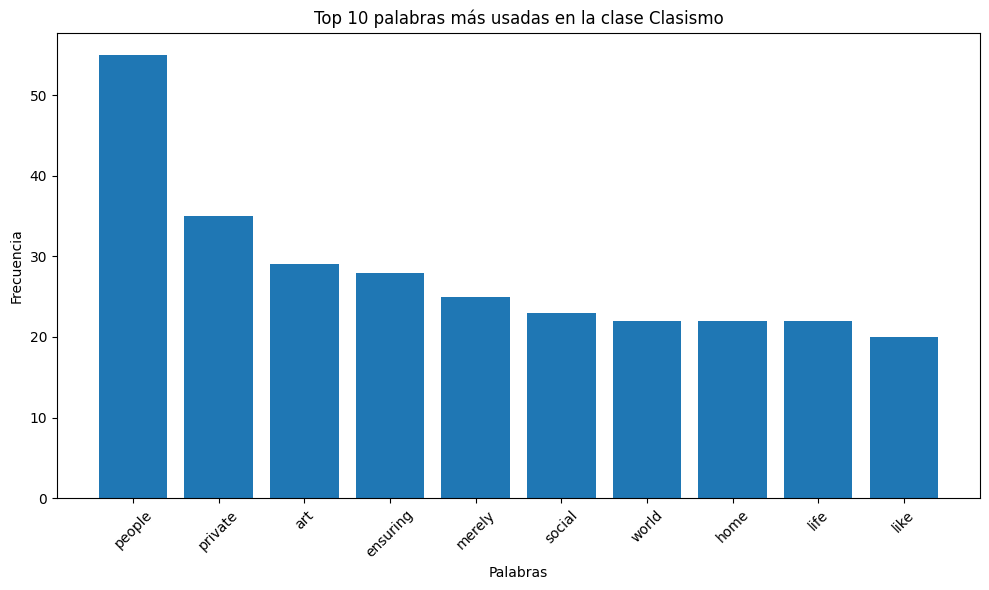

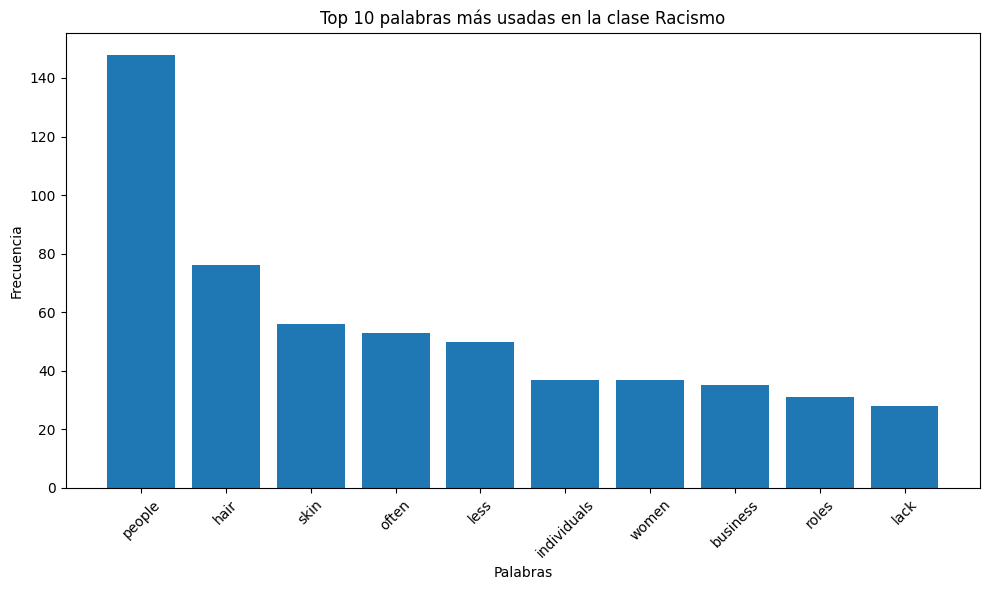

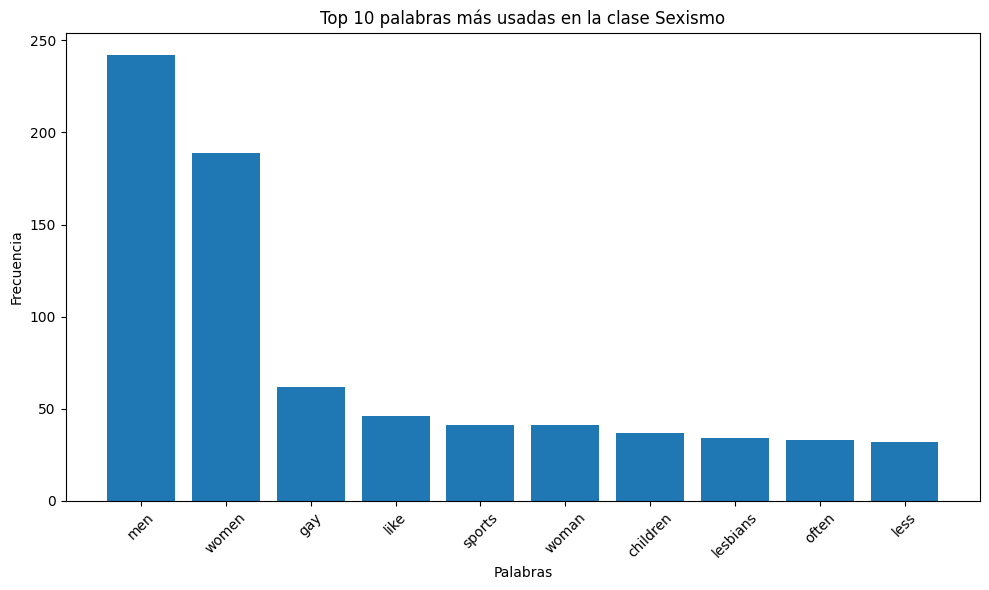

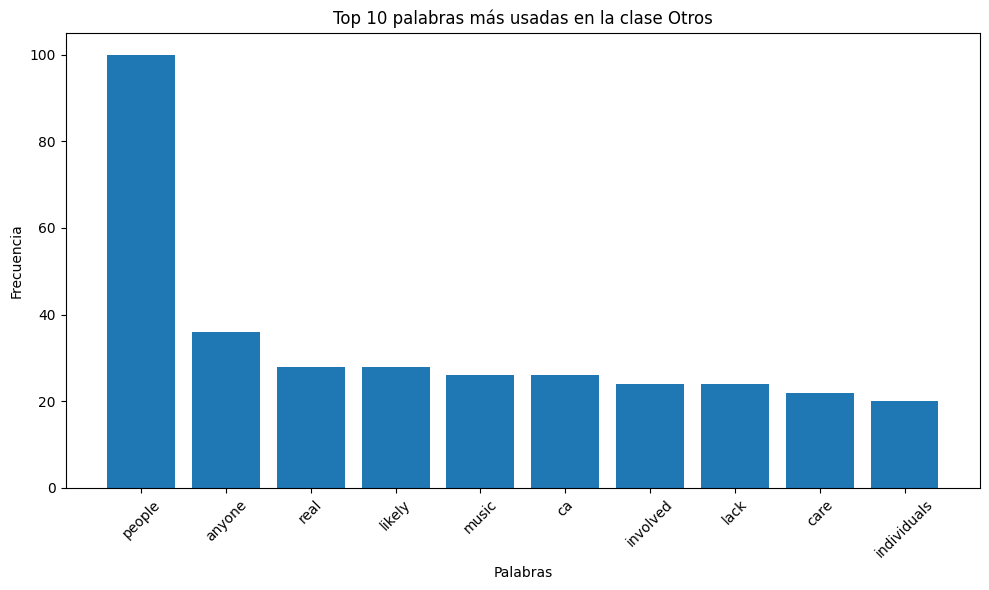

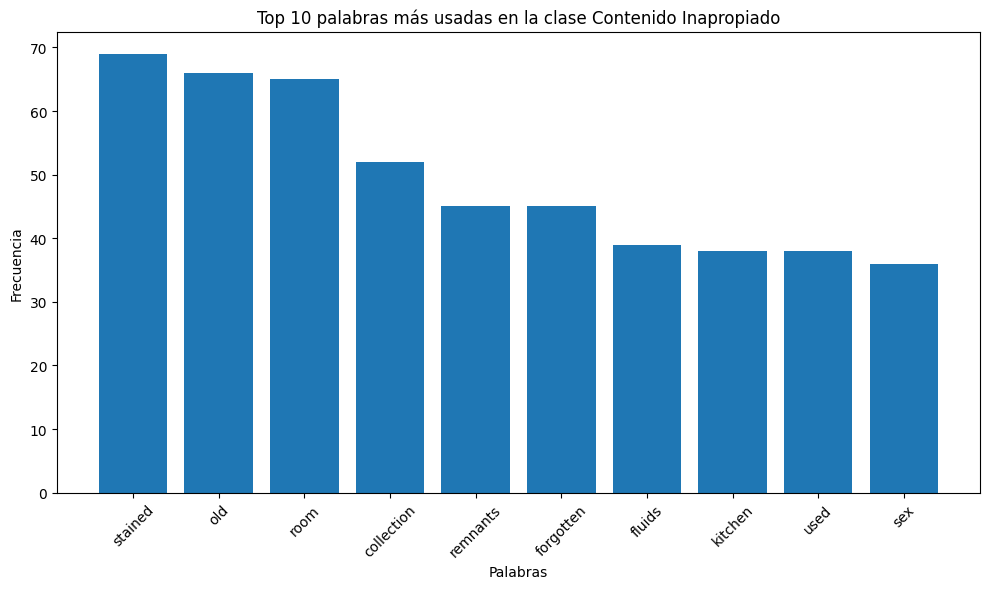

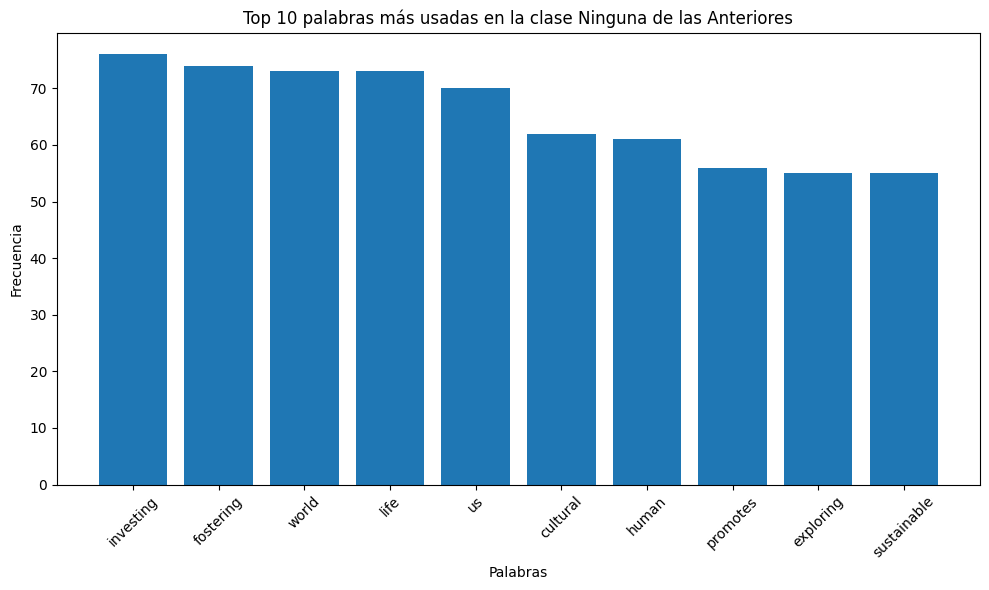

In [80]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descargar los stopwords en caso de no tenerlos
nltk.download('stopwords')
nltk.download('punkt')

def process_text(text):
    # Tokenizar el texto
    tokens = word_tokenize(text.lower())
    
    # Filtrar stopwords y signos de puntuación
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Contar las palabras
    word_counts = nltk.FreqDist(filtered_tokens)
    
    return word_counts

# Agrupar los textos por clase
grouped_data = data.groupby('class')['text']

# Diccionario de nombres de clases
class_names = {
    1: 'Clasismo',
    2: 'Racismo',
    3: 'Sexismo',
    4: 'Otros',
    5: 'Contenido Inapropiado',
    6: 'Ninguna de las Anteriores'
}

# Iterar sobre cada grupo (clase)
for class_id, group_texts in grouped_data:
    # Concatenar los textos de cada grupo en una sola cadena
    combined_text = ' '.join(group_texts)
    
    # Procesar el texto combinado
    word_counts = process_text(combined_text)
    
    # Obtener las 10 palabras más frecuentes
    top_words = word_counts.most_common(10)
    
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
    plt.title(f"Top 10 palabras más usadas en la clase {class_names[class_id]}")
    plt.xlabel("Palabras")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Convirtamos todo el texto a minúsculas y eliminemos los signos de puntuación.

In [81]:
import string

def preprocesamiento_texto(texto):
    # Convertimos a minúsculas
    texto = texto.lower()
    # Eliminamos signos de puntuación
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    return texto

data['text'] = data['text'].apply(preprocesamiento_texto)
data.head()

,text,class
0,public education is in decline luckily my kids...,1
1,it bothers me to have to stand in line like th...,1
2,the poor are only poor because they want to be...,1
3,if you cant afford good wine better not to dri...,1
4,the service in this restaurant is terrible whe...,1


Se dividen los datos en conjuntos de entrenamiento y prueba con una proporción de 80% para entrenamiento y 20% para prueba.

In [82]:
from sklearn.model_selection import train_test_split

X = data['text']  
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test))

Tamaño del conjunto de entrenamiento: 2183
Tamaño del conjunto de prueba: 546


Aplicación de vectorización TF-IDF al texto utilizando la clase TfidfVectorizer de scikit-learn.

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizacion = TfidfVectorizer()
X_train_tfidf = vectorizacion.fit_transform(X_train)
X_test_tfidf = vectorizacion.transform(X_test)

print("Dimensiones de la matriz TF-IDF de entrenamiento:", X_train_tfidf.shape)
print("Dimensiones de la matriz TF-IDF de prueba:", X_test_tfidf.shape)

Dimensiones de la matriz TF-IDF de entrenamiento: (2183, 5946)
Dimensiones de la matriz TF-IDF de prueba: (546, 5946)


Entrenamiento de un clasificador de Regresión Logística utilizando las matrices TF-IDF y evaluación su rendimiento en el conjunto de prueba.

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clasificador = LogisticRegression()
clasificador.fit(X_train_tfidf, y_train)

y_pred = clasificador.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9395604395604396

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.95      0.92      0.93        83
           2       0.94      0.87      0.91        95
           3       0.93      0.97      0.95        87
           4       0.85      0.90      0.87        92
           5       0.98      0.99      0.99       106
           6       0.99      0.99      0.99        83

    accuracy                           0.94       546
   macro avg       0.94      0.94      0.94       546
weighted avg       0.94      0.94      0.94       546



Entrenamiento de un clasificador de Naive Bayes utilizando las matrices TF-IDF y evaluación su rendimiento en el conjunto de prueba.

In [85]:
from sklearn.naive_bayes import MultinomialNB

nb_clasificador = MultinomialNB()
nb_clasificador.fit(X_train_tfidf, y_train)

y_pred_nb = nb_clasificador.predict(X_test_tfidf)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy (Naive Bayes):", accuracy_nb)

print("\nReporte de Clasificación (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

Accuracy (Naive Bayes): 0.9194139194139194

Reporte de Clasificación (Naive Bayes):
              precision    recall  f1-score   support

           1       0.97      0.92      0.94        83
           2       0.93      0.85      0.89        95
           3       0.80      0.97      0.88        87
           4       0.84      0.79      0.82        92
           5       1.00      1.00      1.00       106
           6       0.99      0.99      0.99        83

    accuracy                           0.92       546
   macro avg       0.92      0.92      0.92       546
weighted avg       0.92      0.92      0.92       546



Visualización de la matriz de confusión para el clasificador de Regresión Logística.

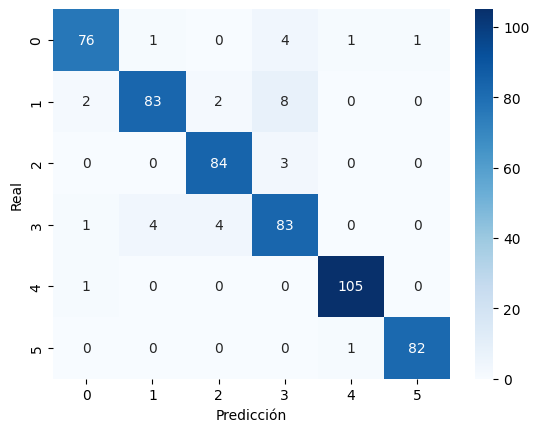

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

mat_conf = confusion_matrix(y_test, y_pred)

sns.heatmap(mat_conf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Visualización de la matriz de confusión para el clasificador de Naive Bayes.

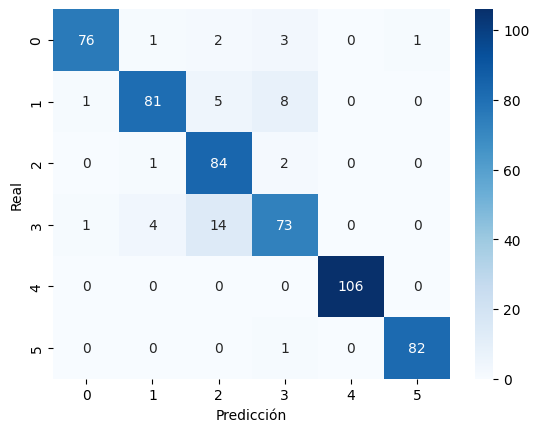

In [87]:
mat_conf_nb = confusion_matrix(y_test, y_pred_nb)

sns.heatmap(mat_conf_nb, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Aplicación de técnicas de preprocesamiento adicionales: eliminación de palabras vacías (stop words), lematización y derivación (stemming).

In [88]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocesamiento_texto(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar signos de puntuación
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenizar
    words = text.split()
    # Eliminar palabras vacías
    words = [word for word in words if word not in stop_words]
    # Lematizar
    words = [lemmatizer.lemmatize(word) for word in words]
    # Derivar
    words = [stemmer.stem(word) for word in words]
    # Unir las palabras de nuevo en un texto
    text = ' '.join(words)
    return text

data['text'] = data['text'].apply(preprocesamiento_texto)
data.head()

[nltk_data] Downloading package wordnet to /home/luis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,class
0,public educ declin luckili kid go exclus priva...,1
1,bother stand line like rest pleb dont know,1
2,poor poor want made hard work,1
3,cant afford good wine better drink anyth,1
4,servic restaur terribl manag demand speak,1


Visualización de la distribución de las clases utilizando un diagrama de barras.

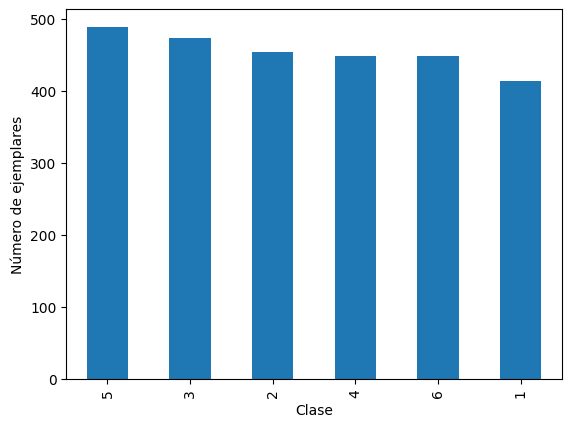

In [89]:
conteo_clases.plot(kind='bar')
plt.xlabel('Clase')
plt.ylabel('Número de ejemplares')
plt.show()

Visualición de la relación entre la longitud del texto y su clase utilizando un diagrama de dispersión.

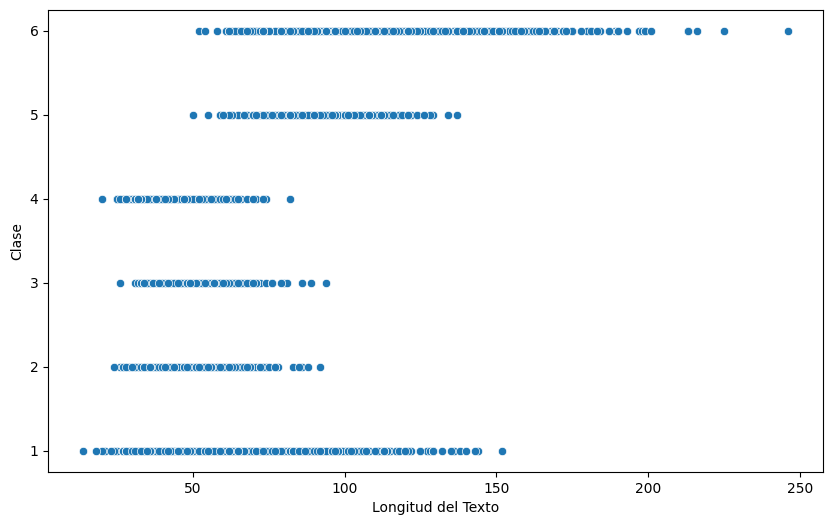

In [90]:
data['text_length'] = data['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='class', data=data)
plt.xlabel('Longitud del Texto')
plt.ylabel('Clase')
plt.show()

Volver a dividir los datos en conjuntos de entrenamiento y prueba, entrenar los modelos de Regresión Logística y Naive Bayes, y evaluar su rendimiento después del preprocesamiento adicional.

In [91]:
from sklearn.model_selection import train_test_split

X = data['text']  
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizacion = TfidfVectorizer()
X_train_tfidf = vectorizacion.fit_transform(X_train)
X_test_tfidf = vectorizacion.transform(X_test)

# Regresión Logística
clasificador = LogisticRegression()
clasificador.fit(X_train_tfidf, y_train)

y_pred = clasificador.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy (Regresión Logística):", accuracy)

print("\nReporte de Clasificación (Regresión Logística):")
print(classification_report(y_test, y_pred))

# Naive Bayes
nb_clasificador = MultinomialNB()
nb_clasificador.fit(X_train_tfidf, y_train)

y_pred_nb = nb_clasificador.predict(X_test_tfidf)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy (Naive Bayes):", accuracy_nb)

print("\nReporte de Clasificación (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

Accuracy (Regresión Logística): 0.9120879120879121

Reporte de Clasificación (Regresión Logística):
              precision    recall  f1-score   support

           1       0.83      0.88      0.85        83
           2       0.95      0.76      0.84        95
           3       0.94      0.97      0.95        87
           4       0.80      0.91      0.85        92
           5       0.99      0.99      0.99       106
           6       0.98      0.96      0.97        83

    accuracy                           0.91       546
   macro avg       0.91      0.91      0.91       546
weighted avg       0.92      0.91      0.91       546

Accuracy (Naive Bayes): 0.8791208791208791

Reporte de Clasificación (Naive Bayes):
              precision    recall  f1-score   support

           1       0.92      0.73      0.82        83
           2       0.91      0.77      0.83        95
           3       0.79      0.94      0.86        87
           4       0.81      0.85      0.83        92
  

In [94]:
# Ejemplos de oraciones para clasificar
ejemplos = [
    "This is a neutral sentence without any offensive content.",
    "Women belong in the kitchen and should not have equal rights.",
    "Immigrants are criminals and should be deported.",
    "People of color are inferior to white people.",
    "Using offensive language is cool and acceptable.",
    "This sentence does not contain any inappropriate content.",
    "Women are only good for cooking and sex.",
    "I want to kill myself and throw myself into a ravine."
]

# Preprocesamiento de las oraciones de ejemplo
ejemplos_preprocesados = [preprocesamiento_texto(ejemplo) for ejemplo in ejemplos]

# Vectorización de las oraciones de ejemplo
ejemplos_tfidf = vectorizacion.transform(ejemplos_preprocesados)

# Predicción de las clases utilizando el clasificador de Regresión Logística
predicciones_rl = clasificador.predict(ejemplos_tfidf)

# Predicción de las clases utilizando el clasificador de Naive Bayes
predicciones_nb = nb_clasificador.predict(ejemplos_tfidf)

# Imprimir los resultados
print("Resultados de la clasificación:")
for i, ejemplo in enumerate(ejemplos):
    print(f"Oración: {ejemplo}")
    print(f"Clase predicha (Regresión Logística): {predicciones_rl[i]}")
    print(f"Clase predicha (Naive Bayes): {predicciones_nb[i]}")
    print()

Resultados de la clasificación:
Oración: This is a neutral sentence without any offensive content.
Clase predicha (Regresión Logística): 1
Clase predicha (Naive Bayes): 3

Oración: Women belong in the kitchen and should not have equal rights.
Clase predicha (Regresión Logística): 3
Clase predicha (Naive Bayes): 3

Oración: Immigrants are criminals and should be deported.
Clase predicha (Regresión Logística): 4
Clase predicha (Naive Bayes): 4

Oración: People of color are inferior to white people.
Clase predicha (Regresión Logística): 2
Clase predicha (Naive Bayes): 2

Oración: Using offensive language is cool and acceptable.
Clase predicha (Regresión Logística): 1
Clase predicha (Naive Bayes): 6

Oración: This sentence does not contain any inappropriate content.
Clase predicha (Regresión Logística): 5
Clase predicha (Naive Bayes): 5

Oración: Women are only good for cooking and sex.
Clase predicha (Regresión Logística): 3
Clase predicha (Naive Bayes): 3

Oración: I want to kill myself 